# Star chart animation

In [1]:
import cairo
import csv
import ephem
import math

from IPython.display import Image
from numpy import linspace
from datetime import timedelta

In [2]:
class Constellation:
    '''A small mutable data structure for storing the constellation data.'''
    
    def __init__(self, label_text, label_point, lines=None, stars=None):
        self.label_text = label_text
        self.label_point = label_point
        
        if lines is None:
            self.lines = list()
        else:
            self.lines = lines

        if stars is None:
            self.stars = list()
        else:
            self.stars = list()
            
    def __repr__(self):
        return "Constellation(\"{0}\", {1}, lines={2}, stars={3})".format(
            self.label_text,
            self.label_point,
            self.lines,
            self.stars
        )

In [3]:
constellations = dict()
with open('constellation_names.csv') as csvfile:
    data = csv.DictReader(csvfile)
    for row in data:
        constellations[row['Code']] = Constellation(
            label_text = row['Name'],
            label_point = ((row['Label RA'],
                           row['Label DEC']))
        )

In [4]:
with open('ConstellationLinesAll2002.csv') as csvfile:
    data = csv.DictReader(csvfile)
    lastpoint = None
    for row in data:
        code = row['CON']
        constellation = constellations[code]
        if '' == row['RA']:
            lastpoint = None
        else:
            star = (float(row['RA']),
                    float(row['DEC']),
                    float(row['MAG']))
            constellation.stars.append(star)

            newpoint = (float(row['RA']), float(row['DEC']))
            if lastpoint is not None:
                constellation.lines.append((lastpoint, newpoint))

            lastpoint = newpoint

In [5]:
bodies = [
    ephem.Sun(),
    ephem.Mercury(),
    ephem.Venus(),
    ephem.Moon(),
    ephem.Mars(),
    ephem.Jupiter(),
    ephem.Saturn(),
    ephem.Uranus(),
    ephem.Neptune()
]

body_symbols = {
    'Sun': u'☉',
    'Venus': u'♀',
    'Mercury': u'☿',
    'Moon': u'☽',
    'Mars': u'♂',
    'Jupiter': u'♃',
    'Saturn': u'♄',
    'Uranus': u'♅',
    'Neptune': u'♆'
}

In [6]:
def make_radec2cart(observer):
    # This is probably not thread safe
    fb = ephem.FixedBody()
    def radec2cart(ra, dec):
        # If ephem.hours or degrees sees a float, it believes it's already a measure in radians.
        fb._ra = ephem.hours(str(ra))
        fb._dec = ephem.degrees(str(dec))
        fb.compute(observer)

        # TODO investigate if some of the normalization can be handled by PyEphem's anorm property
        
        # fix the range from [-90, 90] degrees to [0, 180] degrees
        alt = fb.alt + math.pi/2.0

        # The Horizontal azimuth is measured clockwise from 0 degrees north, so we need to change
        # the sign and rotate by a quarter turn.
        az = ((math.pi*2 - fb.az) - math.pi/2 ) % (math.pi*2)

        sin_alt = math.sin(alt)
        x = sin_alt * math.cos(az)
        y = sin_alt * math.sin(az)
        z = math.cos(alt)
        X = x / (1 - z)
        Y = y / (1 - z)
        return (X, Y)
    return radec2cart

In [7]:

def scale_and_clip(ctx, pos_x, pos_y, radius):
    '''Call Context.save before and Context.restore() and Context.reset_clip() afterwards.'''
    ctx.translate(pos_x, pos_y)
    ctx.scale(radius, radius)
    ctx.arc(0, 0, 1, 0, math.pi*2)
    ctx.clip()

def line_width(ctx, width):
    '''Only works with scaling in the x direction.'''
    return ctx.device_to_user_distance(width, 0)[0]
    
def draw_grid(ctx, radec2cart):
    ctx.set_source_rgb(0, 0, 0)
    ctx.set_line_width(line_width(ctx, 0.5))

    for ra in linspace(0, 24, 24):
        first = True
        for dec in linspace(-90, 90, 180):
            if first:
                ctx.move_to(*radec2cart(ra, dec))
                first = False
            else:
                ctx.line_to(*radec2cart(ra, dec))

    for dec in linspace(-90, 90, 18):
        first = True
        for ra in linspace(0, 24, 240):
            if first:
                ctx.move_to(*radec2cart(ra, dec))
                first = False
            else:
                ctx.line_to(*radec2cart(ra, dec))
    
    ctx.stroke()

def draw_constellations(ctx, constellations, radec2cart):
    ctx.set_source_rgb(0,0,0)
    ctx.set_line_width(line_width(ctx, 1.0))

    for constellation in constellations.values():
        for line in constellation.lines:
            ctx.move_to(*radec2cart(line[0][0], line[0][1]))
            ctx.line_to(*radec2cart(line[1][0], line[1][1]))
    ctx.stroke()

def draw_stars(ctx, constellations, radec2cart):
    for constellation in constellations.values():
        for star in constellation.stars:
            pos = radec2cart(star[0], star[1])

            radius = line_width(ctx, 5 - star[2]/4)

            ctx.set_source_rgb(1, 1, 1)
            ctx.arc(pos[0], pos[1], radius, 0, math.pi*2)
            ctx.fill()
            ctx.set_source_rgb(0,0,0)
            ctx.arc(pos[0], pos[1], radius-line_width(ctx, 2), 0, math.pi*2)
            ctx.fill()

    
def draw_bodies(ctx, bodies, radec2cart):
    ctx.select_font_face('Apple Symbols')
    ctx.set_font_size(line_width(ctx, 72))
    ctx.set_line_width(line_width(ctx, 10))
    for body in bodies:
        pos = radec2cart(body.ra, body.dec)
        name = body_symbols[body.name]
        ext = ctx.text_extents(name)
        ctx.move_to(pos[0] - ext.width/2, pos[1] + ext.height/2)
        ctx.text_path(name)
        ctx.set_source_rgb(1,1,1)
        ctx.stroke_preserve()
        ctx.fill_preserve()
        ctx.set_source_rgb(0,0,0)
        ctx.fill()

def create_star_chart(filename, constellations, bodies, observer, utc_offset, width, height, radius):

    radec2cart = make_radec2cart(observer)

    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, width, height)
    ctx = cairo.Context(surface)

    # Fill the canvas with white
    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0, 0, width, height)
    ctx.fill()

    ctx.save()

    scale_and_clip(ctx, width/2, width/2, radius)

    draw_grid(ctx, radec2cart)
    draw_constellations(ctx, constellations, radec2cart)
    draw_stars(ctx, constellations, radec2cart)
    draw_bodies(ctx, bodies, radec2cart)    

    ctx.reset_clip()
    ctx.set_source_rgb(0,0,0)
    ctx.arc(0,0,1,0, math.pi*2)
    ctx.set_line_width(line_width(ctx,4))
    ctx.stroke()

    ctx.restore()

    surface.write_to_png(filename)

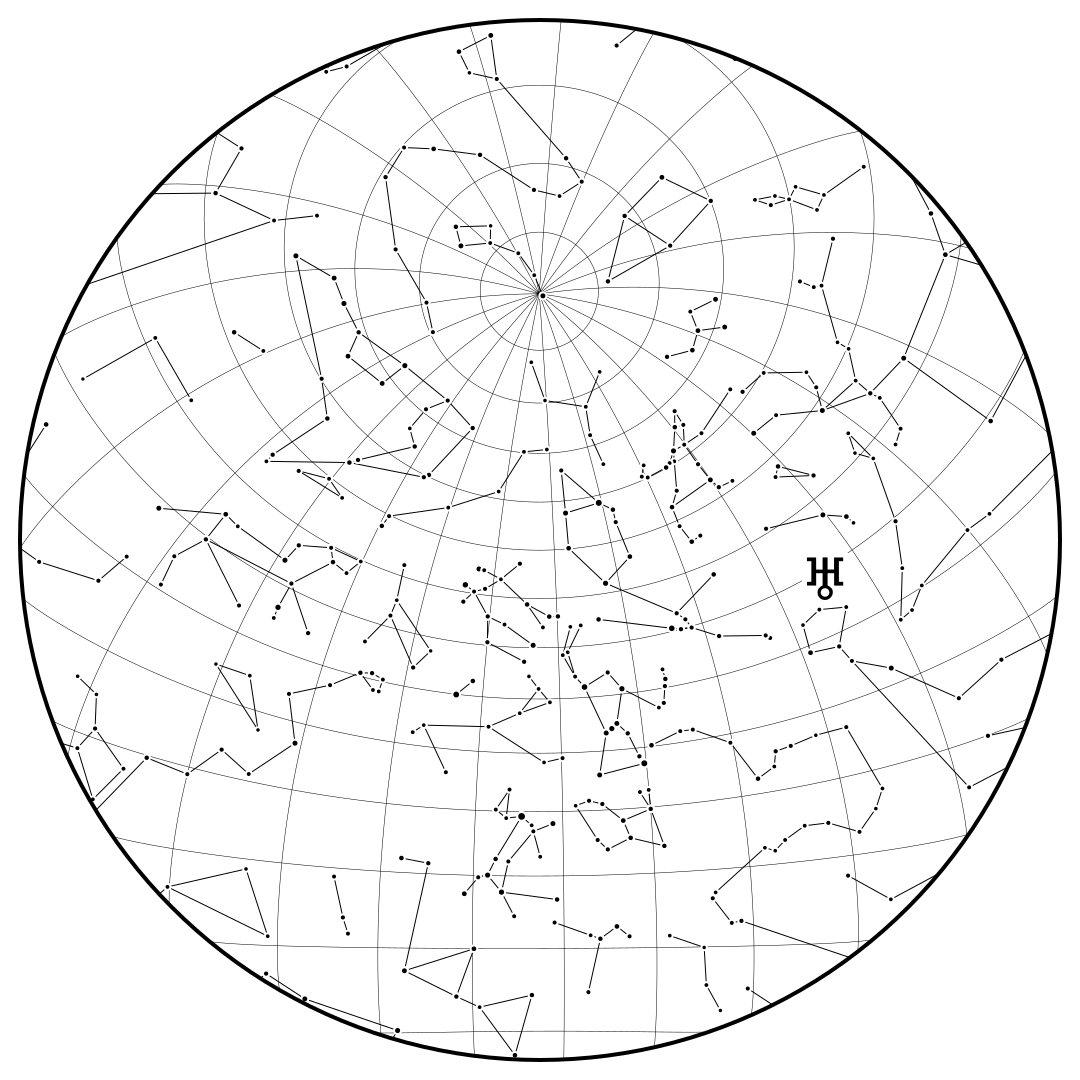

In [11]:
observer = ephem.city('Baltimore')
observer.date = '2018/01/01 05:00:00'

# one day short of a complete loop
for i in range(365*4):
    observer.date = observer.date + 1.0
    
    for body in bodies:
        body.compute(observer)

    filename = 'animation/{0:3d}.png'.format(i)

    create_star_chart(
        filename=filename,
        constellations=constellations,
        bodies=bodies,
        observer=observer,
        utc_offset=-6,
        width=1080,
        height=1080,
        radius=520)
    
Image(filename, retina=True)